# <img src="https://raw.githubusercontent.com/inlab-geo/cofi/main/docs/source/_static/latte_art_cropped.png" width="5%" style="vertical-align:bottom"/> Workshop Notebook 3 (ERT)

[![Open In Colab](https://img.shields.io/badge/open%20in-Colab-b5e2fa?logo=googlecolab&style=flat-square&color=ffd670)](https://colab.research.google.com/github/inlab-geo/workshop-2022/blob/main/notebooks/3_electrical_resistivity_tomography.ipynb)

---

## What we do in this notebook

Here we look at applying CoFI to an electrical resistivity tomography problem,
and compare between different solving approaches.

---

## Learning outcomes (this might need rewording..)

- CoFI's **ease to switch** between fundamentally different inference approaches
- CoFI's **expandability**
- CoFI's **example-driven** feature

In [1]:
# Environment setup (uncomment code lines below)

# !git clone https://github.com/inlab-geo/workshop-2022.git
# %cd workshop-2022/notebooks/

# !pip install -U cofi cofi-espresso

# !pip install -q condacolab
# import condacolab
# condacolab.install()
# !mamba install -c gimli pygimli=1.3

## Eletrical Resistivity Tomography

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import pygimli
from pygimli.physics import ert
from pygimli import meshtools

from cofi import BaseProblem, InversionOptions, Inversion

np.random.seed(42)

In [3]:
############# Utility functions using PyGIMLi ##############################################

# Dipole Dipole (dd) measuring scheme
def survey_scheme(start=0, stop=50, num=51, schemeName="dd"):
    scheme = ert.createData(elecs=np.linspace(start=start, stop=stop, num=num),schemeName=schemeName)
    return scheme

# true geometry, forward mesh and true model
def model_true(scheme, start=[-55, 0], end=[105, -80], anomaly_pos=[10,-7], anomaly_rad=5):
    world = meshtools.createWorld(start=start, end=end, worldMarker=True)
    for s in scheme.sensors():          # local refinement 
        world.createNode(s + [0.0, -0.1])
    conductive_anomaly = meshtools.createCircle(pos=anomaly_pos, radius=anomaly_rad, marker=2)
    geom = world + conductive_anomaly
    rhomap = [[1, 200], [2,  50],]
    mesh = meshtools.createMesh(geom, quality=33)
    return mesh, rhomap

# PyGIMLi ert.ERTManager
def ert_manager(data, verbose=False):
    return ert.ERTManager(data, verbose=verbose, useBert=True)

# inversion mesh
def inversion_mesh(ert_mgr):
    inv_mesh = ert_mgr.createMesh(ert_mgr.data)
    # print("model size", inv_mesh.cellCount())   # 1031
    ert_mgr.setMesh(inv_mesh)
    return inv_mesh

# inversion mesh rectangular (the above is by default triangular)
def inversion_mesh_rect(ert_manager):
    x = np.linspace(start=-5, stop=55, num=40)
    y = np.linspace(start=-20,stop=0,num=10)
    inv_mesh = pygimli.createGrid(x=x, y=y, marker=2)
    inv_mesh = pygimli.meshtools.appendTriangleBoundary(inv_mesh, marker=1, xbound=50, ybound=50)
    # print("model size", inv_mesh.cellCount())    # 1213
    ert_manager.setMesh(inv_mesh)
    return inv_mesh

# PyGIMLi ert.ERTModelling
def ert_forward_operator(ert_manager, scheme, inv_mesh):
    forward_operator = ert_manager.fop
    forward_operator.setComplex(False)
    forward_operator.setData(scheme)
    forward_operator.setMesh(inv_mesh, ignoreRegionManager=True)
    return forward_operator

# regularization matrix
def reg_matrix(forward_oprt):
    region_manager = forward_oprt.regionManager()
    region_manager.setConstraintType(2)
    Wm = pygimli.matrix.SparseMapMatrix()
    region_manager.fillConstraints(Wm)
    Wm = pygimli.utils.sparseMatrix2coo(Wm)
    return Wm

# initialise model
def starting_model(ert_mgr, val=None):
    data = ert_mgr.data
    start_val = val if val else np.median(data['rhoa'].array())     # this is how pygimli initialises
    start_model = np.ones(ert_mgr.paraDomain.cellCount()) * start_val
    start_val_log = np.log(start_val)
    start_model_log = np.ones(ert_mgr.paraDomain.cellCount()) * start_val_log
    return start_model, start_model_log

# convert model to numpy array
def model_vec(rhomap, fmesh):
    model_true = pygimli.solver.parseArgToArray(rhomap, fmesh.cellCount(), fmesh)
    return model_true

Text(0.5, 1.0, 'True model')

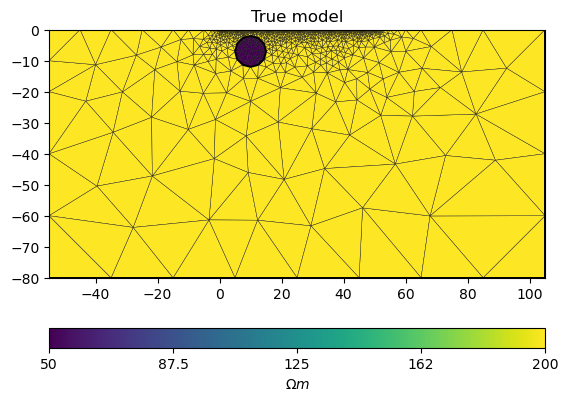

In [4]:
# PyGIMLi - define measuring scheme, geometry, forward mesh and true model
scheme = survey_scheme()
mesh, rhomap = model_true(scheme)

# plot the true model
ax = pygimli.show(mesh, data=rhomap, label="$\Omega m$", showMesh=True)
ax[0].set_title("True model")

In [5]:
# load data and covariance matrix
log_data = np.loadtxt("ert_data_log.txt")
data_cov_inv = np.loadtxt("ert_data_cov_inv.txt")

# create PyGIMLi's ERT manager
ert_mgr = ert_manager("ert_data.dat")

Text(0.5, 1.0, 'Provided data')

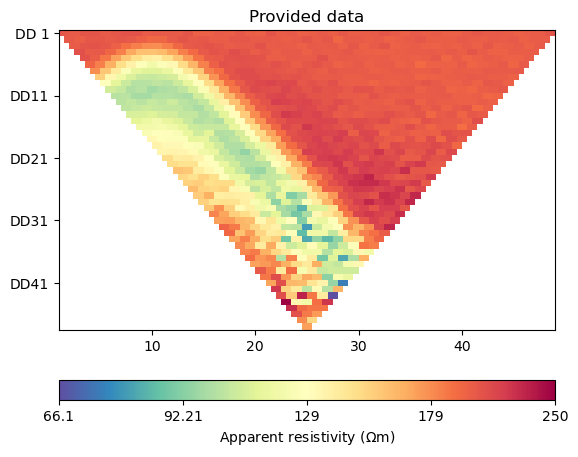

In [6]:
# plot data
data = ert_mgr.data
ax = ert.show(data)
ax[0].set_title("Provided data")

13/10/22 - 12:12:46 - pyGIMLi - INFO - Found 2 regions.
13/10/22 - 12:12:46 - pyGIMLi - INFO - Region with smallest marker (1) set to background


Text(0.5, 1.0, 'Mesh used for inversion')

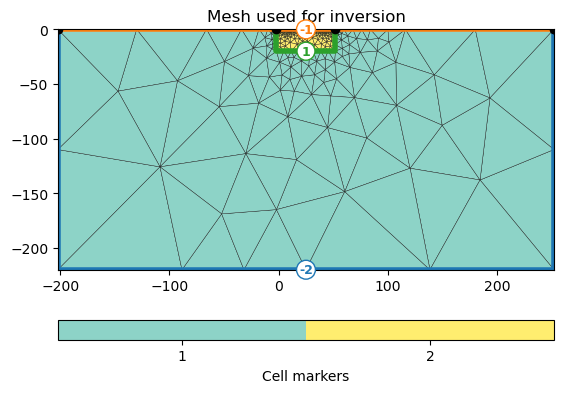

In [7]:
inv_mesh = inversion_mesh(ert_mgr)
ax = pygimli.show(inv_mesh, showMesh=True, markers=True)
ax[0].set_title("Mesh used for inversion")

13/10/22 - 12:12:46 - Core - WARNING - Region Nr: 1  is background and should not get a model transformation.
13/10/22 - 12:12:46 - Core - WARNING - Region Nr: 1  is background and should not get a model control.
13/10/22 - 12:12:46 - pyGIMLi - INFO - Creating forward mesh from region infos.
13/10/22 - 12:12:46 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.


Text(0.5, 1.0, 'Starting model')

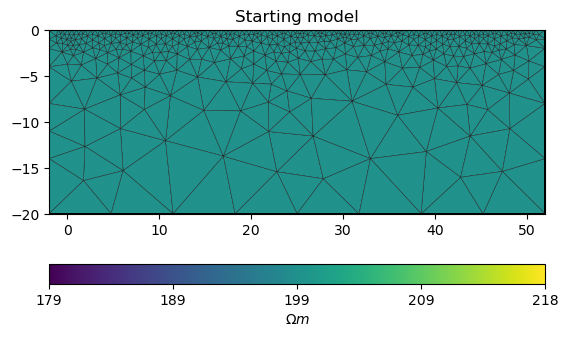

In [8]:
# PyGIMLi's forward operator (ERTModelling)
forward_oprt = ert_forward_operator(ert_mgr, scheme, inv_mesh)

# extract regularisation matrix
Wm = reg_matrix(forward_oprt)

# initialise a starting model for inversion
start_model, start_model_log = starting_model(ert_mgr)
ax = pygimli.show(ert_mgr.paraDomain, data=start_model, label="$\Omega m$", showMesh=True)
ax[0].set_title("Starting model")

In [9]:
############# Functions provided to CoFI ##############################################

## Note: all functions below assume the model in log space!

def get_response(model, forward_operator):
    return np.log(np.array(forward_operator.response(np.exp(model))))

def get_residual(model, log_data, forward_operator):
    response = get_response(model, forward_operator)
    residual = log_data - response
    return residual

def get_jacobian(model, forward_operator):
    response = get_response(model, forward_operator)
    forward_operator.createJacobian(np.exp(model))
    J = np.array(forward_operator.jacobian())
    jac = J / np.exp(response[:, np.newaxis]) * np.exp(model)[np.newaxis, :]
    return jac

def get_jac_residual(model, log_data, forward_operator):
    response = get_response(model, forward_operator)
    residual = log_data - response
    forward_operator.createJacobian(np.exp(model))
    J = np.array(forward_operator.jacobian())
    jac = J / np.exp(response[:, np.newaxis]) * np.exp(model)[np.newaxis, :]
    return jac, residual

def get_data_misfit(model, log_data, forward_operator, data_cov_inv=None):
    residual = get_residual(model, log_data, forward_operator)
    data_cov_inv = np.eye(log_data.shape[0]) if data_cov_inv is None else data_cov_inv
    return np.abs(residual.T @ data_cov_inv @ residual)

def get_regularization(model, Wm, lamda):
    model = np.exp(model)
    return lamda * (Wm @ model).T @ (Wm @ model)

def get_objective(model, log_data, forward_operator, Wm, lamda, data_cov_inv=None):
    data_misfit = get_data_misfit(model, log_data, forward_operator, data_cov_inv)
    regularization = get_regularization(model, Wm, lamda)
    obj = data_misfit + regularization
    return obj

def get_gradient(model, log_data, forward_operator, Wm, lamda, data_cov_inv=None):
    jac, residual = get_jac_residual(model, log_data, forward_operator)
    data_cov_inv = np.eye(log_data.shape[0]) if data_cov_inv is None else data_cov_inv
    data_misfit_grad =  - residual.T @ data_cov_inv @ jac
    regularization_grad = lamda * Wm.T @ Wm @ np.exp(model)
    return data_misfit_grad + regularization_grad

def get_hessian(model, log_data, forward_operator, Wm, lamda, data_cov_inv=None):
    jac = get_jacobian(model, forward_operator)
    data_cov_inv = np.eye(log_data.shape[0]) if data_cov_inv is None else data_cov_inv
    hess = jac.T @ data_cov_inv @ jac + lamda * Wm.T @ Wm
    return hess

In [10]:
# hyperparameters
lamda = 0.0001

# CoFI - define BaseProblem
ert_problem = BaseProblem()
ert_problem.name = "Electrical Resistivity Tomography defined through PyGIMLi"
ert_problem.set_forward(get_response, args=[forward_oprt])
ert_problem.set_jacobian(get_jacobian, args=[forward_oprt])
ert_problem.set_residual(get_residual, args=[log_data, forward_oprt])
ert_problem.set_data_misfit(get_data_misfit, args=[log_data, forward_oprt, data_cov_inv])
ert_problem.set_regularization(get_regularization, args=[Wm, lamda])
ert_problem.set_gradient(get_gradient, args=[log_data, forward_oprt, Wm, lamda, data_cov_inv])
ert_problem.set_hessian(get_hessian, args=[log_data, forward_oprt, Wm, lamda, data_cov_inv])
ert_problem.set_initial_model(start_model_log)

In [11]:
ert_problem.suggest_solvers();

Based on what you've provided so far, here are possible solvers:
{
    "optimization": [
        "scipy.optimize.minimize",
        "scipy.optimize.least_squares"
    ],
    "matrix solvers": [
        "cofi.simple_newton"
    ],
    "sampling": []
}


In [12]:
inv_options_scipy = InversionOptions()
inv_options_scipy.set_tool("scipy.optimize.minimize")
inv_options_scipy.set_params(method="trust-krylov", options={"maxiter": 10})

class CallbackFunction:
    def __init__(self):
        self.x = None
        self.i = 0

    def __call__(self, xk):
        print(f"Iteration #{self.i}")
        if self.x is not None:
            print(f"  model change: {np.linalg.norm(xk - self.x)}")
        print(f"  objective value: {ert_problem.objective(xk)}")
        self.x = xk
        self.i += 1
    
inv_options_scipy.set_params(callback=CallbackFunction())

In [13]:
inv = Inversion(ert_problem, inv_options_scipy)
inv_result = inv.run()
# inv_result.summary()
print(f"\nSolver message: {inv_result.message}")

13/10/22 - 12:12:47 - Core - WARNING -  data contains no K-factors but we calculate them  analytically for the response call


Iteration #0
  objective value: 157.50708172346378
Iteration #1
  model change: 2.0000000000000004
  objective value: 68.94013122104028
Iteration #2
  model change: 2.088598198678278
  objective value: 51.744476378629784
Iteration #3
  model change: 2.23576838207677
  objective value: 32.60775764541542
Iteration #4
  model change: 1.7295706120934284
  objective value: 29.21317518511378
Iteration #5
  model change: 0.0
  objective value: 29.21317518511378
Iteration #6
  model change: 1.0000000000048133
  objective value: 16.606163553099535
Iteration #7
  model change: 0.0
  objective value: 16.606163553099535
Iteration #8
  model change: 0.5000000000000001
  objective value: 11.968202845278581
Iteration #9
  model change: 0.0
  objective value: 11.968202845278581

Solver message: Maximum number of iterations has been exceeded.


Text(0.5, 1.0, 'True model')

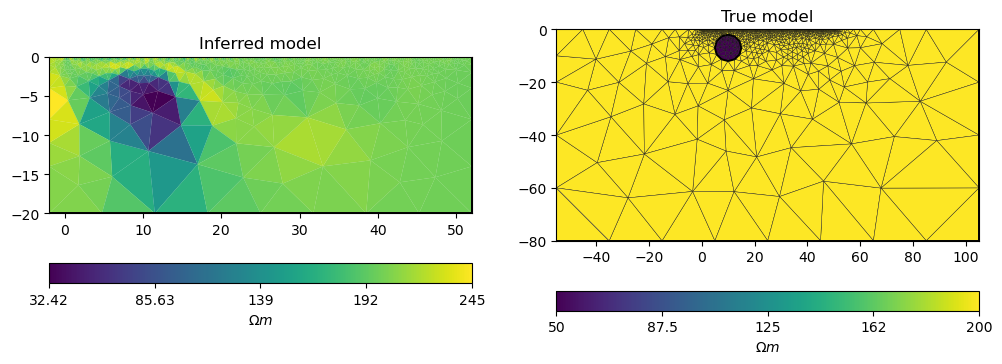

In [14]:
# convert back to normal space from log space
model = np.exp(inv_result.model)

_, axes = plt.subplots(1, 2, figsize=(12,4))

# plot inferred model
# inv_result.summary()
pygimli.show(ert_mgr.paraDomain, data=model, label=r"$\Omega m$", ax=axes[0])
axes[0].set_title("Inferred model")

# plot the true model
pygimli.show(mesh, data=rhomap, label="$\Omega m$", showMesh=True, ax=axes[1])
axes[1].set_title("True model")

Text(0.5, 1.0, 'Provided data')

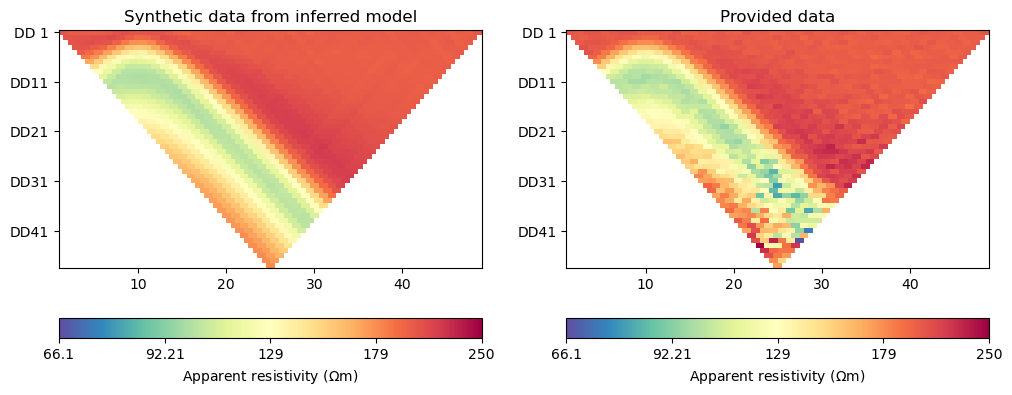

In [15]:
_, axes = plt.subplots(1, 2, figsize=(12,4))

# plot synthetic data
d = forward_oprt.response(model)
ert.showERTData(scheme, vals=d, cMin=np.min(data["rhoa"]), cMax=np.max(data["rhoa"]), ax=axes[0])
axes[0].set_title("Synthetic data from inferred model")

# plot given data
ert.show(data, ax=axes[1])
axes[1].set_title("Provided data")

---
## Watermark

In [16]:
watermark_list = ["cofi", "numpy", "scipy", "pygimli", "matplotlib"]
for pkg in watermark_list:
    pkg_var = __import__(pkg)
    print(pkg, getattr(pkg_var, "__version__"))

cofi 0.1.2.dev13
numpy 1.21.6
scipy 1.9.1
pygimli 1.2.6
matplotlib 3.5.3
